In [11]:
import os
import numpy as np
import pandas as pd
import math
import copy
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.coordinates import SkyCoord
#--------------------------------------
import rubin_sim.phot_utils as phot_utils
import rubin_sim.maf as maf
from rubin_sim.phot_utils import signaltonoise, PhotometricParameters
from rubin_sim.data import get_data_dir
from rubin_sim.data import get_baseline
#---------------------------------------
from pyLIMA.simulations import simulator
from pyLIMA import event
from pyLIMA import telescopes
from pyLIMA.models import PSPL_model


def mag_star(params):
    mags = [float(params[f][0:params[f].index('-')]) for f in ('w','u','g','r','i','z','y')]
    g = [float(params[f][params[f].index('-'):-1]) for f in ('w','u','g','r','i','z','y')]
    return mags, g

def mag(zp, Flux):
    '''
    Transform the flux to magnitude
    inputs
    zp: zero point
    Flux: vector that contains the lightcurve flux
    '''
    return zp-2.5*np.log10(abs(Flux))

def set_photometric_parameters(exptime, nexp, readnoise=None):
    # readnoise = None will use the default (8.8 e/pixel). Readnoise should be in electrons/pixel.
    photParams = PhotometricParameters(exptime=exptime, nexp=nexp, readnoise=readnoise)
    return photParams


In [4]:
LSST_BandPass = {}
lsst_filterlist = 'ugrizy'
for f in lsst_filterlist:
    LSST_BandPass[f] = phot_utils.Bandpass()
    # print(os.path.join(get_data_dir(), 'throughputs', 'baseline', f'total_{f}.dat'))
    LSST_BandPass[f].read_throughput(os.path.join(get_data_dir(), 'throughputs', 'baseline', f'total_{f}.dat'))
photParams = set_photometric_parameters(30,1)

Ra = 267.92
Dec = -29.15

baseline_file =get_baseline()
name = os.path.basename(baseline_file).replace('.db','')

outDir = 'temp'
resultsDb = maf.db.ResultsDb()

print(baseline_file)
print(name)

bundleList = []
ra = [Ra]
dec = [Dec]
print(ra,dec)
metric = maf.metrics.PassMetric(cols=['filter', 'observationStartMJD', 'fiveSigmaDepth'])
sql = ''
slicer = maf.slicers.UserPointsSlicer(ra=ra, dec=dec)
bundleList.append(maf.MetricBundle(metric, slicer, sql))

example1_bg = maf.MetricBundleGroup(
    bundleList, baseline_file, out_dir=outDir)
example1_bg.run_all()
dataSlice = bundleList[0].metric_values[0]

filters = ['u', 'g', 'r', 'i', 'z', 'y']

time_series = {}
for fil in filters:
    int_array = np.empty((0, 3), int)
    for i in range(len(dataSlice['fiveSigmaDepth'][np.where(dataSlice['filter'] == fil)])):
        m5 = dataSlice['fiveSigmaDepth'][np.where(dataSlice['filter'] == fil)][i]
        mjd = dataSlice['observationStartMJD'][np.where(dataSlice['filter'] == fil)][i] + 2400000.5
        mags = np.random.uniform(15., m5 - 0.15)
        int_array = np.append(int_array, [[mjd, m5, m5]], axis=0)
    time_series[fil] = int_array


/home/anibal/rubin_sim_data/sim_baseline/baseline_v2.0_10yrs.db
baseline_v2.0_10yrs
[267.92] [-29.15]


<class 'float'>
Parallax(Full) estimated for the telescope u: SUCCESS
Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope z: SUCCESS
Parallax(Full) estimated for the telescope y: SUCCESS


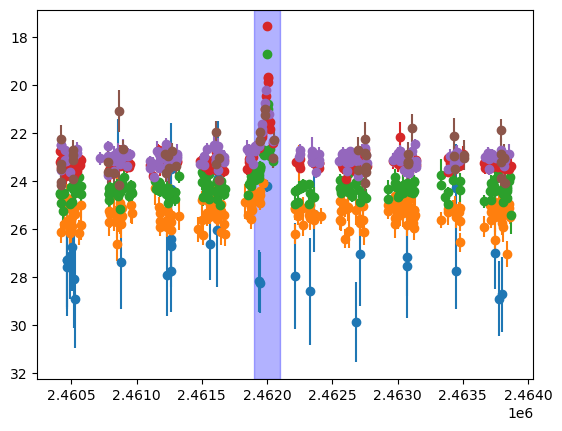

In [39]:
my_own_creation = event.Event(ra=Ra, dec=Dec)
my_own_creation.name = 'An event observed by Rubin'

LSST_u = telescopes.Telescope(name='u', camera_filter='u', location='Earth', light_curve=time_series['u'].astype(float),
                              light_curve_names = ['time','mag','err_mag'], light_curve_units = ['JD','mag','mag'])

LSST_g = telescopes.Telescope(name='g', camera_filter='g', location='Earth', light_curve=time_series['g'].astype(float),
                              light_curve_names = ['time','mag','err_mag'], light_curve_units = ['JD','mag','mag'])


LSST_r = telescopes.Telescope(name='r', camera_filter='r', location='Earth', light_curve=time_series['r'].astype(float),
                              light_curve_names = ['time','mag','err_mag'],light_curve_units = ['JD','mag','mag'])


LSST_i = telescopes.Telescope(name='i', camera_filter='i', location='Earth', light_curve=time_series['i'].astype(float),
                              light_curve_names = ['time','mag','err_mag'],light_curve_units = ['JD','mag','mag'])


LSST_z = telescopes.Telescope(name='z', camera_filter='z', location='Earth', light_curve=time_series['z'].astype(float),
                              light_curve_names = ['time','mag','err_mag'], light_curve_units = ['JD','mag','mag'])

LSST_y = telescopes.Telescope(name='y', camera_filter='y', location='Earth', light_curve=time_series['y'].astype(float),
                              light_curve_names = ['time','mag','err_mag'], light_curve_units = ['JD','mag','mag'])

my_own_creation.telescopes.append(LSST_u)
my_own_creation.telescopes.append(LSST_g)
my_own_creation.telescopes.append(LSST_r)
my_own_creation.telescopes.append(LSST_i)
my_own_creation.telescopes.append(LSST_z)
my_own_creation.telescopes.append(LSST_y)

my_own_creation.telescopes[0].ld_gamma = 0.5
my_own_creation.telescopes[1].ld_gamma = 0.5
my_own_creation.telescopes[2].ld_gamma = 0.5
my_own_creation.telescopes[3].ld_gamma = 0.5
my_own_creation.telescopes[4].ld_gamma = 0.5
my_own_creation.telescopes[5].ld_gamma = 0.5

cero_p = [ 27.03, 28.38, 28.16, 27.85,  27.46, 26.68]

new_creation = copy.deepcopy(my_own_creation)

# uniform source with point lenss
params = {'t0': 2462000.0, 'u0': 0.001, 'tE': 100,'piEN': 0.3,
          'piEE': 0.1}
t0 = params['t0']
print(type(t0))
my_own_parameters = []
for key in params:
    my_own_parameters.append(params[key])

my_own_model = PSPL_model.PSPLmodel(new_creation ,parallax=['Full', t0])
pyLIMA_parameters_1 = my_own_model.compute_pyLIMA_parameters(my_own_parameters)

magstar = [27.94, 25.112, 23.791, 23.052, 22.687, 22.509]

fs = []
my_own_flux_parameters = []
np.random.seed(i)
G = []
for m in range(len(magstar)):
    ZP = cero_p[m]
    mag_baseline = magstar[m]
    flux_baseline = 10**((ZP-mag_baseline)/2.5)
    g = np.random.uniform(0,1)
    G.append(g)
    f_source = flux_baseline/(1+g)
    fs.append(f_source)
    my_own_flux_parameters.append(f_source)
    my_own_flux_parameters.append(g)
my_own_parameters += my_own_flux_parameters
pyLIMA_parameters = my_own_model.compute_pyLIMA_parameters(my_own_parameters)
simulator.simulate_lightcurve_flux(my_own_model, pyLIMA_parameters)

for k in range(len(new_creation.telescopes)):
    model_flux = my_own_model.compute_the_microlensing_model(new_creation.telescopes[k],
                                                             pyLIMA_parameters)['photometry']
    new_creation.telescopes[k].lightcurve_flux['flux'] = model_flux
%matplotlib inline

j=0
for telo in new_creation.telescopes:
    X = telo.lightcurve_flux['time'].value
    ym = mag(cero_p[j],telo.lightcurve_flux['flux'].value)
    z = []
    y = []
    x = []
    M5 = []
    for k in range(len(ym)):
        m5 = dataSlice['fiveSigmaDepth'][np.where(dataSlice['filter'] == filters[j])][k]
        magerr = signaltonoise.calc_mag_error_m5(ym[k],  LSST_BandPass[filters[j]], m5 , photParams)[0]
        z.append(magerr)
        y.append(np.random.normal(ym[k],magerr))
        x.append(X[k])
        M5.append(m5)
    plt.errorbar(x,y,z,linestyle=' ',marker='o')
    j += 1
plt.axvspan(t0-params['tE'], t0+params['tE'], color='blue',alpha=0.3)

plt.gca().invert_yaxis()
plt.show()